In [1]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%aimport pygenesig.file_formats
%aimport pygenesig.visualization
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
from pygenesig.file_formats import * 
from pygenesig.visualization import *
from validation.validation import process_configuration_files
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics as skm 
import os.path
import dask
from dask import compute
from dask.distributed import Client, LocalCluster
import tempfile
from collections import Counter
from os import environ
import os.path

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 


# Signature Crossvalidation Pipeline
This notebook uses [pygenesig](https://github.com/grst/pygenesig) to generate and validate signatures. 

## Contents
* Load configuration and data
* Split data into folds, generate signatures on each fold
* Test signatures on each fold 
* Calculate and visualize performance (confusion matrix, precision, recall) 
* Generate signatures on the entire dataset
* Export signatures to GMT

## Load configuration and data
read configuration file: 

In [2]:
os.chdir(os.environ.get('workdir', os.getcwd()))
config = process_configuration_files(os.environ['config_file'])
config

{'expr_file': '/pstore/home/sturmg/projects/pygenesig-example/data_processed/v6/expr_solid.npy',
 'job_template': '/pstore/home/sturmg/projects/pygenesig-pipeline/validation/job.template',
 'mem': '200G',
 'n_jobs': 10,
 'n_splits': 10,
 'out_dir': '/pstore/data/bioinfo/users/sturmg/gtex-signatures/results/gtex_v6_solid_gini_0.8_1',
 'queue': 'short',
 'results_dir': '/pstore/home/sturmg/projects/pygenesig-example/results',
 'rosetta_file': '/pstore/home/sturmg/projects/pygenesig-example/data_processed/v6/rosetta.csv',
 'scheduler': 'sbatch',
 'sg_kwargs': {'max_rel_rk': 0.33,
  'max_rk': 3,
  'min_expr': 5,
  'min_gini': 0.8},
 'signature_generator': pygenesig.gini.GiniSignatureGenerator,
 'signature_tester': pygenesig.bioqc.BioQCSignatureTester,
 'st_kwargs': {},
 'target_file': '/pstore/home/sturmg/projects/pygenesig-example/data_processed/v6/target_solid.csv',
 'tmp_dir': '/pstore/scratch/bioinfo/users/sturmg'}

read data

In [3]:
splitter = sklearn.model_selection.StratifiedKFold(n_splits=config["n_splits"])
target = read_target(config["target_file"])
exprs = read_gct(config["expr_file"]) if config["expr_file"].endswith(".gct") else read_expr(config["expr_file"])
rosetta = read_rosetta(config["rosetta_file"])

### filter input data for having enough samples per class
Cross-validation requires at least as many samples per class as we split data into folds. Here, we remove all classes from the input data that do not have enough samples

In [4]:
## Remove tissues which have not enough samples and save the new target and expression matrix to a temporary file. 
exprs_fil, target_fil = filter_samples(exprs, target, n_splits=10)
exprs_tmp = tempfile.NamedTemporaryFile(delete=False, dir=config['tmp_dir'], suffix=".npy")
target_tmp = tempfile.NamedTemporaryFile(delete=False, dir=config['tmp_dir'], suffix=".csv")
write_expr(exprs_fil, exprs_tmp.name)
write_target(target_fil, target_tmp.name)
exprs_tmp.close()
target_tmp.close()

The following tissues have been removed because they have less than `n_splits` samples:

In [5]:
set(target) - set(target_fil)

set()

## Perform crossvalidation
Magic crossvalidation of *pygenesig* happening here...

In [6]:
target = target_fil
exprs = exprs_fil
st = config["signature_tester"](exprs, target, **config["st_kwargs"])
sg = config["signature_generator"](exprs, target, **config["sg_kwargs"])
cluster = LocalCluster(n_workers=config.get('n_jobs', config["n_splits"]), threads_per_worker=1)
client = Client(cluster)

In [7]:
sig_list, res_list, train_list, test_list = cv_score(exprs_tmp.name,
                                                    target_tmp.name,
                                                    config["signature_generator"],
                                                    config["signature_tester"],
                                                    splitter,
                                                    sg_kwargs=config["sg_kwargs"])

Do the actual computation:

In [8]:
signatures, scores, train_inds, test_inds = compute(sig_list, res_list, train_list, test_list,
                                                    get=client.get,
                                                    num_workers=config.get('n_jobs', config["n_splits"]))

## Results
### Heatmap of average scores, clipped at Score=30 
For each of the folds, we calculate the mean score per sample group, resulting in a score matrix. 
We take the average of these score matrices and display it as a heatmap. 

In [9]:
heatmaps = []
for i, test in enumerate(test_inds):
    sig_labels = config["signature_tester"].sort_signatures(signatures[i])
    heatmaps.append(aggregate_scores(sig_labels, scores[i], target[test]))

In [10]:
heatmap_avg = np.mean([hm.as_matrix() for hm in heatmaps], axis=0)

In [11]:
heatmap_df = pd.DataFrame(heatmap_avg)
heatmap_df.index = heatmaps[0].index
heatmap_df.columns = heatmaps[0].columns

(<matplotlib.figure.Figure at 0x2aab582e1f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aab58b6af98>)

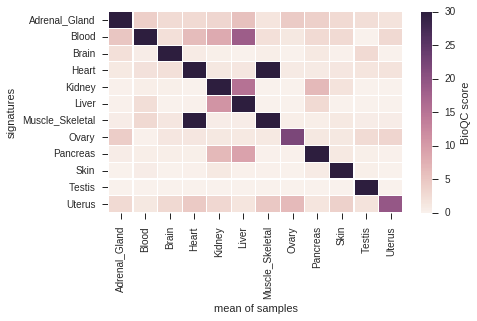

In [12]:
plot_score_heatmap(heatmap_df)

### Heatmap of Classification (Confusion Matrix)
For each of the folds, we calculate the confusion matrix, by drilling down the scores to a classification task. 
A sample is considered as 'true positive' if the signature associated with the sample's tissue of origin scores highest. 
We calculate the average confusion matrix over all folds and display it as heatmap

In [13]:
actual_predicted = [st.classify(signatures[0], score, subset) for score, subset in zip(scores, test_inds)]
cms = [st.confusion_matrix(signatures[0], actual, predicted) for actual, predicted in actual_predicted]
conf_mat_mean = np.apply_along_axis(normalize_sum, 1, np.mean(np.array(cms), axis=0)) * 100
sig_labels = BioQCSignatureTester.sort_signatures(signatures[0])

(<matplotlib.figure.Figure at 0x2aab58b717b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aab58b92128>)

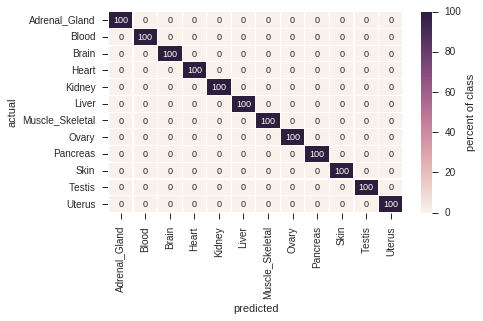

In [14]:
plot_confusion_matrix_heatmap(conf_mat_mean, sig_labels)

### Median Performance on all folds
Based on the confusion matrices, we can compute performance measures used in machine learning. 
The following table shows the median [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall) over all folds for each signature. 

In [15]:
prec = performance_per_tissue(cms, sig_labels, pm.prec_pos)
recall = performance_per_tissue(cms, sig_labels, pm.sens)
prec_median = {tissue: np.median(perf) for tissue, perf in prec.items()}
recall_median = {tissue: np.median(perf) for tissue, perf in recall.items()}

In [16]:
pd.DataFrame().assign(Precision=pd.Series(prec_median), Recall=pd.Series(recall_median))

,Precision,Recall
Adrenal_Gland,1.0,1.0
Blood,1.0,1.0
Brain,1.0,1.0
Heart,1.0,1.0
Kidney,1.0,1.0
Liver,1.0,1.0
Muscle_Skeletal,1.0,1.0
Ovary,1.0,1.0
Pancreas,1.0,1.0
Skin,1.0,1.0


### Signature overlap between the folds
The box-plot shows the overlap of the signatures between the different folds. A high jaccard index indicates stability of the signatures between the folds. A low jaccard index can indicate a lack of signal or noisy data. 

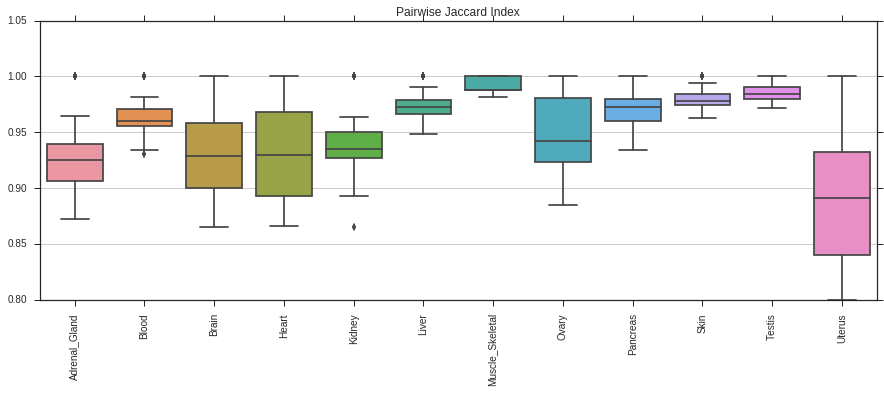

In [17]:
pairwise_jaccard = pairwise_jaccard_ind(signatures)
fig, ax = subplots(figsize=(15,5))
data=pd.DataFrame(pairwise_jaccard)
sns.boxplot(data=data, ax=ax)
ax.set_title("Pairwise Jaccard Index")
ax.set_xticklabels(data.columns, rotation=90);

## Export signatures
We export two GMT files
* The first is based on the cross-validation. Only genes will be included in the cross-validation which appear in *all* folds. Like that, only stable genes make it into the final signature
* For the second, we re-generate the signature on the entire dataset.

### combine signatures from the differnt folds into one

In [18]:
sigs_combined = combine_signatures(*signatures)
sigs_combined_hgnc = translate_signatures(sigs_combined, rosetta)

### re-generate signatures on the entire dataset

In [19]:
signatures = sg.mk_signatures()
signatures_hgnc = translate_signatures(signatures, rosetta)

### Score heatmap based on the re-generated signatures,  clipped at Score=30 
Just to make sure nothing went wrong... should look more or less the same as the average score heatmap from the top of this document.

In [20]:
scores = st.score_signatures(signatures)
sig_labels = config["signature_tester"].sort_signatures(signatures)
scores_df = aggregate_scores(sig_labels, scores, target)

/pstore/home/sturmg/projects/pygenesig/pygenesig/bioqc.py:157: RuntimeWarning: divide by zero encountered in log10
  bioqc_res_log = -np.log10(bioqc_res)


(<matplotlib.figure.Figure at 0x2aab5ba4ef60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aab589bb320>)

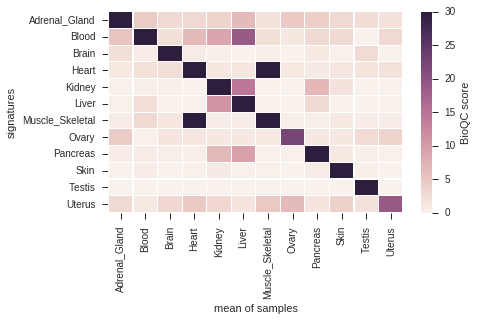

In [21]:
plot_score_heatmap(scores_df)

### Overlap between tissue signatures, pairwise jaccard index
The following heatmap shows the pairwise overlap of the signatures

In [22]:
jac_mat = jaccard_mat(signatures_hgnc, signatures_hgnc, as_matrix=True)

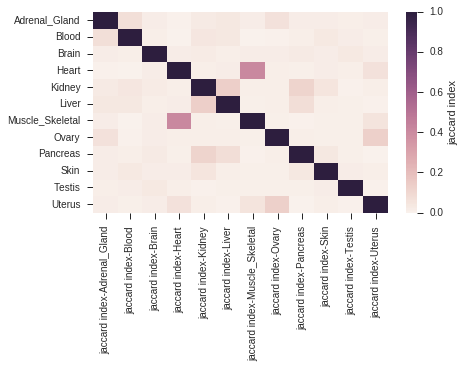

In [23]:
fig, ax = subplots(figsize=heatmap_figsize(len(signatures)))
sns.heatmap(jac_mat, ax=ax, cbar_kws={'label': 'jaccard index'})
ax.set_xlabel("")
ax.set_ylabel("")

### signature sizes

In [24]:
pd.DataFrame().assign(normal=pd.Series({
        tissue: len(genes) for tissue, genes in signatures_hgnc.items()}), 
                     fold_overlap=pd.Series({tissue:len(genes) for tissue, genes in sigs_combined_hgnc.items()}))

,fold_overlap,normal
Adrenal_Gland,71,80
Blood,249,269
Brain,272,302
Heart,115,121
Kidney,173,194
Liver,309,322
Muscle_Skeletal,156,157
Ovary,46,51
Pancreas,139,147
Skin,306,316


### Export gmt

In [25]:
write_gmt(signatures_hgnc, os.path.join(config["out_dir"], 'signatures.gmt'))
write_gmt(sigs_combined_hgnc, os.path.join(config["out_dir"], 'signatures_fold_intersections.gmt'))